In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from qiskit.quantum_info import DensityMatrix, Operator
from qiskit import QuantumCircuit

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Random Forest

Test notebook for Random Forest.

Training a random forest model is usefull to establish a baseline for the performance of the model, due to the absence of hyperparameters of the model.
It is also usefull to understand the importance of the features in the model.

## Haar dataset

### Working with density matrices

The dataset `ds_haar_op.csv` contains the operator to generate the state.
We can give the entries of the density matrix as features to the model.

In [5]:
def get_operator_from_datapoint(datapoint):
    """Get an Operator from a datapoint.

    Return the qiskit operator from a datapoint of either the 2 or 3 qubit operator entries datasets.

    Args:
        datapoint (np.1darray): A datapoint with shape (16,), (17,), (64,) or (65,). It is assumed that length 17 and 65
        include y label.
    Returns:
        Operator: An Operator.
    Raises:
        ValueError: If the length of the datapoint is not 16, 17, 64, 65.
    """
    if len(datapoint) in [16, 17]:
        datapoint = datapoint[:16]
        datapoint = np.array(datapoint).reshape(4, 4)
    elif len(datapoint) in [64, 65]:
        datapoint = datapoint[:64]
        datapoint = np.array(datapoint).reshape(8, 8)
    else:
        raise ValueError("The length of the datapoint is not 16, 17, 64, 65.")
    return Operator(datapoint)

In [6]:
# load datset
dataset = pd.read_csv('../datasets/ds_haar_op.csv')

# create dataset of density matrix from operators
new_dataset = []
for row in dataset.iterrows():
    # get density matrix
    U = get_operator_from_datapoint(row[1])
    qc = QuantumCircuit(2)
    qc.unitary(U, [0, 1])
    rho = DensityMatrix.from_instruction(qc)
    
    # append features and label
    x_complex = rho.data.flatten().tolist()
    x = []
    # append real and imaginary parts of the complex numbers as random forest can't handle complex numbers
    for cn in x_complex:
        x.append(cn.real)
        x.append(cn.imag)
    y = row[1]["sep"]
    
    new_dataset.append(x + [y])

In [8]:
# train test split

X = [datapoint[:-1] for datapoint in new_dataset]
y = [datapoint[-1] for datapoint in new_dataset]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
# train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# evaluate model
score = model.score(X_test, y_test)
print(f"Accuracy: {score}")

RandomForestClassifier()

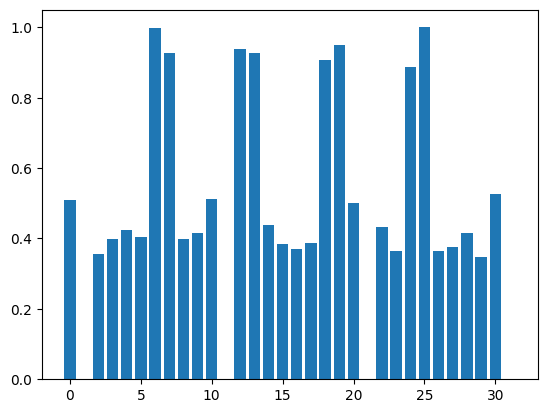

In [16]:
# get feature importance
importances = model.feature_importances_
importances = np.abs(importances)
importances = importances / np.max(importances)

# plot histogram
plt.bar(range(len(importances)), importances)
plt.show()

### Working with observables

The dataset `ds_haar_obs.csv` contains the expectation value of the Pauli operators for each qubit.
We can give the expectation values as features to the model.

In [28]:
# load datset
dataset = pd.read_csv('../datasets/ds_haar_obs.csv')

# train test split
X = dataset.drop(columns=["sep"]).values
y = dataset["sep"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
# train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# evaluate model
score = model.score(X_test, y_test)
print(f"Accuracy: {score}")

Accuracy: 0.9975


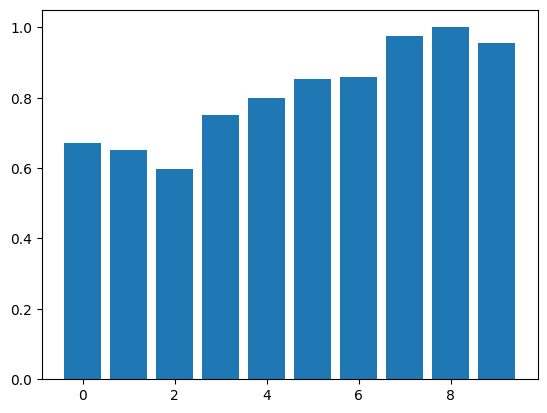

In [31]:
# get feature importance
importances = model.feature_importances_
importances = np.abs(importances)
importances = importances / np.max(importances)

# plot histogram
plt.bar(range(len(importances)), importances)
plt.show()